# Programación Evolutiva

La librería **Pyristic** incluye una clase llamada `EvolutionaryProgramming` inspirada en la metaheurística de *Programación Evolutiva* (PE) para resolver problemas de minimización. Para trabajar con esta clase se requiere hacer lo siguiente:

1. Definir:
    * La función objetivo $f$.
    * La lista de restricciones.
    * Lista de límites inferiores y superiores.
    * Configuración de operadores de la metaheurística (opcional). 
    
2. Crear una clase que hereda de `EvolutionaryProgramming`.

3. Sobreescribir las siguientes funciones:
    
    * mutation_operator (opcional)
    * adaptive_mutation (opcional)
    * survivor_selection (opcional)
    * initialize_step_weights (opcional)
    * initialize_population (opcional)
    * fixer (opcional)
    
A continuación se muestran los elementos que se deben importar.

### Librerías externas

In [2]:
from pprint import pprint
import math
import numpy as np 
import copy

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

### Componentes de `pyristic`
La estructura que está organizada la librería es:
 * Las metaheurísticas están ubicadas en `heuristic`.
 * Las funciones de prueba están ubicadas en `utils.test_function`.
 * Las clases auxiliares para mantener la información de los operadores que serán empleados para alguna de las metaheurísticas basadas en los paradigmas del cómputo evolutivo están ubicadas en `utils.helpers`.
 * Las metaheurísticas basadas en los paradigmas del cómputo evolutivo dependen de un conjunto de operadores (selección, mutación y cruza). Estos operadores están ubicados en `utils.operators`.
 
Para demostrar el uso de nuestra metaheurística basada en *algoritmos geneticos* tenemos que importar la clase llamada `Genetic` que se encuentra en `heuristic.GeneticAlgorithm_search`.


In [4]:
from pyristic.heuristic.EvolutiveProgramming_search import EvolutionaryProgramming
from pyristic.utils.helpers import EvolutionaryProgrammingConfig, get_stats, ContinuosFixer
from pyristic.utils.test_function import beale_, ackley_
from pyristic.utils.operators import mutation, selection

## Función de Beale
\begin{equation}
  \label{eq:BF}
  \begin{array}{rll}
  \text{minimizar:} & f(x_1, x_2) = (1.5 - x_1 + x_1x_2)^2 + (2.25 - x_1 + x_1x_2^2)^2 + (2.625 - x_1 + x_1x_2^3)^2
  &  \\
  \text{tal que: } & -4.5 \leq x_1,x_2 \leq 4.5 &  
  \end{array}
\end{equation}

El mínimo global se encuentra en $x^* = (3, 0.5)$ y $f(x^*) = 0$. 


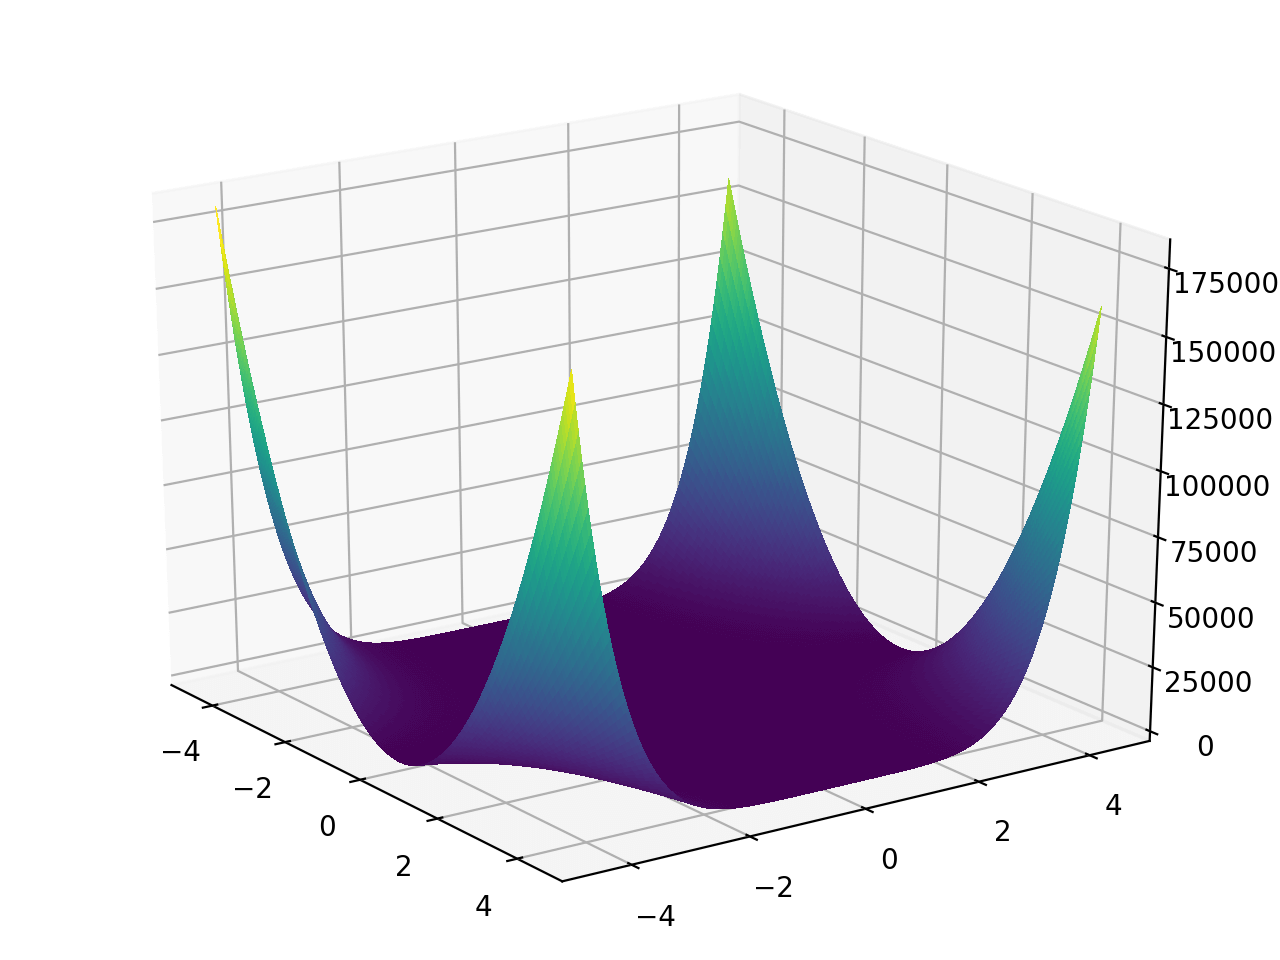

In [4]:
Image(filename="include/beale.png", width=500, height=300)

Para inicializar un objeto de la clase `EvolutionaryProgramming`, es necesario implementar los siguientes elementos.

#### Función objetivo

In [5]:
def f(x : np.ndarray) -> float:
    a = (1.5 - x[0] + x[0]*x[1])**2
    b = (2.25 - x[0] + x[0]*x[1]**2)**2
    c = (2.625 - x[0] + x[0]*x[1]**3)**2
    return a+b+c

### Función de aptitud
Los algoritmos evolutivos, se define una función llamada **aptitud** que describe a cada individuo que tan bueno es en el problema a resolver. Los valores más grandes de aptitud corresponden a las mejores soluciones. Para el problema de Beale, la función de aptitud es:
$F_a(i) = \frac{1}{f(x^{(i)}_1, x^{(i)}_2) + 1}$

In [5]:
def aptitudeBeale(X: np.array) -> np.array:
    return 1/ ( beale_['function'](X)+1)

#### Restricciones
Las restricciones se definen como una lista de funciones que retornan valores booleanos, estos valores permiten revisar si una solución es factible o no. En el caso de la función de Beale, solo se tienen restricciones de caja.

In [6]:
def is_feasible(x : np.ndarray) -> bool:
    for i in range(len(x)):
        if -4.5>x[i] or x[i] > 4.5:
            return False 
    is_feasible.__doc__="x1: -4.5 <= {:.2f} <= 4.5 \n x2: -4.5 <= {:.2f} <= 4.5".format(x[0],x[1])

    return True

constraints_ = [is_feasible]

#### Límites de las variables del problema
Los límites de las variables de decisión son establecidos en una matriz (lista de listas) de tamaño (2 x $n$), donde $n$ es el número de variables. La primera fila contiene los límites inferiores de cada una de las variables de decisión y la segunda fila los límites superiores.

In [7]:
lower_bound = [-4.5,-4.5]
upper_bound = [4.5, 4.5]
bounds = [lower_bound, upper_bound]

*Nota:* En el caso de que todas las variables de decisión se encuentren en el mismo rango de búsqueda, se puede utilizar una única lista con dos valores numéricos, donde, el primer valor representa el límite inferior y el segundo el límite superior.


Por ejemplo, la función de Beale es una función de dos variables ($x_{1}, x_{2}$). La dos variables están acotadas en el mismo espacio de búsqueda $ -4.5 < x_{i} < 4.5, i \in [1,2]$, entonces, en lugar de emplear la representación descrita antes, podemos sustituirla por:

``` python
bounds = [-4.5, 4.5]
``` 

En esta representación, la primera componente se refiere al límite inferior, mientras, la segunda componente es el límite superior. Este arreglo será interpretado como el espacio de búsqueda para todas las variables de decisión.


La librería **Pyristic** tiene implementados algunos problemas de prueba en `utils.helpers.test_function`, entre ellos la función de Beale. Los problemas de prueba están definidos como diccionarios con las siguientes llaves:

 * `function.` Función objetivo.
 * `contraints.` Restricciones del problema, lista con al menos una función que regresa un valor booleano.
 * `bounds.` Límites para cada una de las variables del problema. En el caso de que todas las variables del problema se encuentren en el mismo intervalo de búsqueda, se puede emplear una lista con dos valores numéricos.
 * `decision_variables.` Número de variables de decisión.



In [8]:
beale_

{'function': CPUDispatcher(<function beale_function at 0x7f6ba0e198b0>),
 'constraints': [<function pyristic.utils.test_function.constraint1_beale(X: numpy.ndarray) -> bool>],
 'bounds': [-4.5, 4.5],
 'decision_variables': 2}

### Declaración de `EvolutionaryProgramming`

La metaheurística de PE implementada en la librería **Pyristic** se puede utilizar de las siguientes maneras: 

* Crear una clase que herede de la clase `EvolutionaryProgramming` y sobreescribir las funciones antes mencionadas.
* Declarar un objeto del tipo `EvolutionaryProgrammingConfig` y ajustar los operadores.
* Realizar una combinación de las dos anteriores. 

Es importante resaltar que se puede hacer uso de `EvolutionaryProgramming` sin modificar los operadores que tiene por defecto.

### Ejecución de la metaheurística
Como mencionamos antes, una forma de utilizar la metaheurística es hacer una instancia de la clase `EvolutionProgramming` dejando su configuración por defecto.

Los argumentos que se deben indicar al momento de inicializar son:
 * función objetivo
 * restricciones del problema
 * límites inferior y superior (por cada variable de decisión)
 * número de variables que tiene el problema.


In [9]:
Beale_optimizer = EvolutionaryProgramming(
                    function= aptitudeBeale,\
                    decision_variables=beale_['decision_variables'],\
                    constraints= beale_['constraints'],\
                    bounds= beale_['bounds'])

Recordemos que `beale_` es un diccionario con la información requerida por el constructor de la clase `EvolutionaryProgramming`.

Finalmente, se llama a la función `optimize`. Recibe los siguientes parámetros:

* **generations**. Número de generaciones (iteraciones de la metaheurística).
* **size_population**. Tamaño de la población (número de individuos).
* **verbose**. Muestra en qué iteración se encuentra nuestra búsqueda, por defecto está en True.
* **\**kwargs**. Argumentos externos a la búsqueda.

Para resolver la función de Beale utilizaremos los siguientes parámetros:
* **generations** = $200$
* **size_population** = $100$
* **verbose** = True.


In [10]:
Beale_optimizer.optimize(200,100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 223.39it/s]


In [11]:
print(Beale_optimizer)

Evolutive Programming search: 
 F_a(X) = 1.0 
 X = [3.00000001 0.5       ] 
 Constraints: 
 x1: -4.5 <= 3.00 <= 4.5 
 x2: -4.5 <= 0.50 <= 4.5 



Para revisar el comportamiento de la metaheurística en determinado problema, la librería **Pyristic** cuenta con una función llamada `get_stats`. Esta función se encuentra en `utils.helpers` y recibe como parámetros:

* Objeto que realiza la búsqueda de soluciones.
* El número de veces que se quiere ejecutar la metaheurística.
* Los argumentos que recibe la función `optimize` (debe ser una tupla).
* Argumentos adicionales a la búsqueda, estos argumentos deben estar contenidos en un diccionario (opcional).

La función `get_stats` retorna un diccionario con algunas estadísticas de las ejecuciones. 

In [14]:
args = (200, 100, False)
statistics = get_stats(Beale_optimizer, 30, args, transformer=beale_['function'])

In [15]:
pprint(statistics)

{'Best solution': {'f': 2.1431188661133875e-18, 'x': array([3. , 0.5])},
 'Mean': 6.229694100936672e-17,
 'Median': 7.374433686893511e-17,
 'Standard deviation': 3.2720654171454563e-17,
 'Worst solution': {'f': 1.0924603215227395e-16,
                    'x': array([2.99999998, 0.49999999])},
 'averageTime': 0.10969734191894531,
 'objectiveFunction': [8.048811559930819e-17,
                       2.289416364432771e-17,
                       3.607849917446062e-17,
                       1.0320615431195559e-16,
                       7.944800393900452e-17,
                       6.4332215359194425e-18,
                       1.0157734476307879e-16,
                       1.0514829731443774e-16,
                       9.490973515410499e-18,
                       7.704563232606173e-17,
                       2.968045869330417e-17,
                       1.0924603215227395e-16,
                       2.365116079066699e-17,
                       4.872643436285018e-17,
                    

## Función de Ackley

\begin{equation}
  \min f(\vec{x}) = -20\exp \left( -0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2} \right) 
  - exp \left( \frac{1}{n} \sum_{i=1}^n \cos (2\pi x_i) \right)
  + 20 + e  
\end{equation}

El mínimo global está en $x^* = 0 $ y $f(\vec{x}) = 0$ y su dominio es $|x_{i}| < 30$.

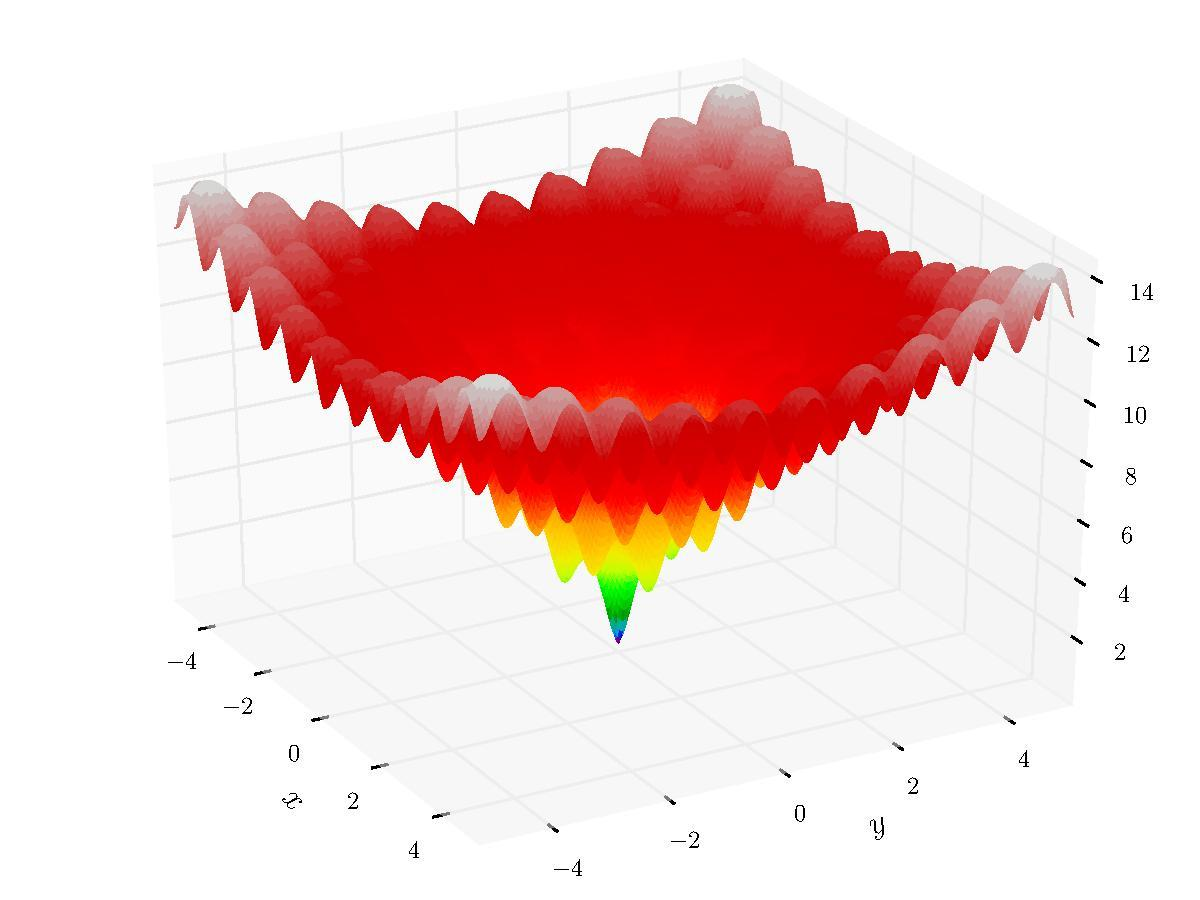

In [14]:
Image(filename="include/ackley.jpg", width=500, height=300)

In [15]:
ackley_

{'function': CPUDispatcher(<function ackley_function at 0x7fb8aa53fa70>),
 'constraints': [<function pyristic.utils.test_function.constraint1_ackley(X: numpy.ndarray) -> bool>],
 'bounds': [-30.0, 30.0],
 'decision_variables': 10}

### Función de aptitud
Los algoritmos evolutivos, se define una función llamada **aptitud** que describe a cada individuo que tan bueno es en el problema a resolver. Los valores más grandes de aptitud corresponden a las mejores soluciones. Para el problema de Ackley, la función de aptitud es: $F_a(\vec{X}) = -f(\vec{X})$

In [21]:
def aptitudeAckley(x):
    return -1* ackley_['function'](x)

En el caso de la función de Ackley, al no estár con restricción de variables de decisión, podemos modificar el número de variables de decisión que tiene por defecto de la siguiente manera:

```python
ackley_['decision_variable'] = 5
```


Para resolver la función de Ackley con 10 variables de decisión utilizaremos los siguientes parámetros:
* **generations** = $500$
* **size_population** = $100$

In [22]:
Optimizer_by_default = EvolutionaryProgramming(
                    function= aptitudeAckley,\
                    decision_variables=ackley_['decision_variables'],\
                    constraints= ackley_['constraints'],\
                    bounds= ackley_['bounds'])

In [23]:
Optimizer_by_default.optimize(500,100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 560.86it/s]


In [24]:
print(Optimizer_by_default)

Evolutive Programming search: 
 F_a(X) = -15.647465362579322 
 X = [ 5.86266763e-04 -6.98901662e+00 -1.69733781e+01  6.00283257e+00
  3.99533234e+00  4.99416496e+00 -5.99300138e+00  4.97435358e+00
  8.99742078e+00  2.15461089e+00] 
 Constraints: 
 x1: -30 <= 0.00 <= 30 
 x2: -30 <= -6.99 <= 30 
 x3: -30 <= -16.97 <= 30 
 x4: -30 <= 6.00 <= 30 
 x5: -30 <= 4.00 <= 30 
 x6: -30 <= 4.99 <= 30 
 x7: -30 <= -5.99 <= 30 
 x8: -30 <= 4.97 <= 30 
 x9: -30 <= 9.00 <= 30 
 x10: -30 <= 2.15 <= 30 
  



La solución encontrada por PE no es la solución óptima. A continuación mostraremos la ejecución de la metaheurística modificando la configuración por defecto.

### Declaración de `EvolutionaryProgramming` por configuración

 A continuación vamos a mostrar la forma en que se declara un objeto del tipo `EvolutionaryProgrammingConfig` que es una clase auxiliar, donde, contendrá los operadores que se emplea en la ejecución de la metaheurística.

In [25]:
configuration = (EvolutionaryProgrammingConfig()
                 .adaptive_mutation(
                     mutation.sigma_ep_adaptive_mutator(ackley_['decision_variables'], 2.0)
                     ) 
                 )

En este ejemplo mostraremos el impacto de inicializar el operador de mutación en los tamaños de paso con $\alpha = 2$, el constructor en caso de no incluir este parámetro lo inicializa con $\alpha = 0.5$.


In [26]:
print(configuration)

--------------------------------
	Configuration
--------------------------------
Adaptive mutation: Sigma EP.
		-Alpha: 2.0

--------------------------------


In [28]:
Optimizer_by_configuration = EvolutionaryProgramming(                    
                    function= aptitudeAckley,\
                    decision_variables=ackley_['decision_variables'],\
                    constraints= ackley_['constraints'],\
                    bounds= ackley_['bounds'], config=configuration)

A diferencia del ejemplo de la función de Beale, incluimos la configuración de los operadores que deseamos utilizar en la variable llamada `config` al crear un objeto de la clase `EvolutionaryProgramming`.

In [29]:
Optimizer_by_configuration.optimize(500,100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 314.08it/s]


In [30]:
print(Optimizer_by_configuration)

Evolutive Programming search: 
 F_a(X) = -5.783655429050093 
 X = [-2.06086488  0.31218006 -0.20826685  0.2928079   0.38471493  1.00622001
 -2.35934164  0.78976161  1.07340558  0.63316748] 
 Constraints: 
 x1: -30 <= -2.06 <= 30 
 x2: -30 <= 0.31 <= 30 
 x3: -30 <= -0.21 <= 30 
 x4: -30 <= 0.29 <= 30 
 x5: -30 <= 0.38 <= 30 
 x6: -30 <= 1.01 <= 30 
 x7: -30 <= -2.36 <= 30 
 x8: -30 <= 0.79 <= 30 
 x9: -30 <= 1.07 <= 30 
 x10: -30 <= 0.63 <= 30 
  



### Herencia desde *EvolutionaryProgramming*

Otra forma de utilizar la metaheurística de nuestra librería es definiendo una clase que herede de `EvolutionaryProgramming`, donde, vamos a sobreescribir el método `adaptive_mutation` y así permitir incluir distintos valores para $\alpha$. 

In [31]:
class EPAckley(EvolutionaryProgramming):
    def __init__(self, function, decision_variables, constraints, bounds):
        super().__init__(function, decision_variables, constraints, bounds)
    
    def adaptive_mutation(self, **kwargs):
        alpha_ = kwargs['alpha']
        return mutation.sigma_ep_adaptive(self.logger['parent_population_sigma'], alpha_)

In [32]:
additional_arguments = {'alpha':2.0}

El diccionario que hemos definido tiene el parámetro que se utiliza en la función `adaptive_mutation`. 

In [33]:
Optimizer_by_class = EPAckley(                    
                    function= aptitudeAckley,\
                    decision_variables=ackley_['decision_variables'],\
                    constraints= ackley_['constraints'],\
                    bounds= ackley_['bounds'])

In [34]:
Optimizer_by_class.optimize(500,100,**additional_arguments)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 391.06it/s]


In [35]:
print(Optimizer_by_class)

Evolutive Programming search: 
 F_a(X) = -2.9561236284566523 
 X = [-0.1334492   1.18713481  0.08050283  0.36162691 -0.19901667 -0.08075823
 -0.14892765 -0.14658668 -0.49483221  0.0610385 ] 
 Constraints: 
 x1: -30 <= -0.13 <= 30 
 x2: -30 <= 1.19 <= 30 
 x3: -30 <= 0.08 <= 30 
 x4: -30 <= 0.36 <= 30 
 x5: -30 <= -0.20 <= 30 
 x6: -30 <= -0.08 <= 30 
 x7: -30 <= -0.15 <= 30 
 x8: -30 <= -0.15 <= 30 
 x9: -30 <= -0.49 <= 30 
 x10: -30 <= 0.06 <= 30 
  



### Resultados

#### Usando la configuración por defecto

In [36]:
args = (500,100,False)
statistics = get_stats(Optimizer_by_default, 21, args, transformer= ackley_['function'])

In [37]:
pprint(statistics)

{'Best solution': {'f': 9.489954602531355,
                   'x': array([ 7.48504226e-03,  2.95889774e+00, -1.06791238e-06,  9.93535418e-01,
        1.05511397e+00,  9.49200577e-01,  1.99131625e+00, -1.90153476e+00,
        8.94072066e+00, -9.93535461e-01])},
 'Mean': 14.492460589077005,
 'Median': 15.559750510791902,
 'Standard deviation': 2.3455987739468203,
 'Worst solution': {'f': 17.156631057399604,
                    'x': array([  0.99931624, -18.98699396,  -0.99931669,  12.10343398,
         4.01515318,  -0.98929879, -15.78665951,  -8.98472587,
        -2.99795011,   2.00004025])},
 'averageTime': 0.8513134207044329,
 'objectiveFunction': [12.777297679560899,
                       12.406833529181537,
                       14.083536142973134,
                       16.800613106244633,
                       9.489954602531355,
                       15.057791215058161,
                       10.449131089552125,
                       16.68123918413538,
                       1

#### Indicando la configuración que va a utilizar PE

In [38]:
args = (500,100,False)
statistics = get_stats(Optimizer_by_configuration, 21, args, transformer=ackley_['function'])

In [39]:
pprint(statistics)

{'Best solution': {'f': 0.029287817357147805,
                   'x': array([-0.00426866,  0.00534723, -0.00170857, -0.0010333 ,  0.00220746,
        0.00212973, -0.01755105,  0.00292507,  0.00193953,  0.00843677])},
 'Mean': 2.7019942601835094,
 'Median': 2.5940331825658594,
 'Standard deviation': 2.2110813051360494,
 'Worst solution': {'f': 7.289008993511484,
                    'x': array([-1.96274221,  0.70338244, -4.02897573,  0.64427953, -1.01778197,
        0.23516911,  1.92776857, -0.68012092, -1.8522765 , -0.39711665])},
 'averageTime': 1.1438583873567127,
 'objectiveFunction': [1.6051577661032188,
                       3.241443587533056,
                       3.3412607640409218,
                       3.31182433320938,
                       2.5940331825658594,
                       1.6533708007822523,
                       3.388535255046403,
                       5.552430766576389,
                       7.289008993511484,
                       0.20580164133764045,
   

#### Creando una clase que hereda de *EvolutionaryProgramming*


In [41]:
args = (500,100,False)
statistics = get_stats(Optimizer_by_class, 21, args, additional_arguments, transformer=ackley_['function'])

In [42]:
pprint(statistics)

{'Best solution': {'f': 0.049198728033769346,
                   'x': array([ 0.00300847, -0.00246123,  0.02117608, -0.00407913,  0.00715526,
        0.02350065,  0.00663271, -0.00296736,  0.00465342, -0.00020478])},
 'Mean': 3.238377435477685,
 'Median': 3.119950444459253,
 'Standard deviation': 2.508550379078093,
 'Worst solution': {'f': 11.151284914348276,
                    'x': array([-2.44136739, -3.97790818,  0.17080317, -0.6755243 ,  5.76987493,
       -2.25352512,  6.96104396, -1.96664209,  0.89479934,  1.15176168])},
 'averageTime': 1.107221319561913,
 'objectiveFunction': [2.912133556162623,
                       0.18101380168871772,
                       4.046180176489283,
                       0.2294355607766687,
                       3.119950444459253,
                       4.376114865669642,
                       3.486013401633333,
                       2.084503839331284,
                       3.4247044497448056,
                       3.573510949549498,
       

Las últimas dos estrategias utilizan la misma configuración, la única diferencia es la forma en que se han creado y los resultados obtenidos pueden variar por los números aleatorios generados.